#### IMPORTS


In [295]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
import folium
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
from datetime import datetime, timedelta
import contextily as cx
import geopandas as gpd
from shapely.geometry import Point


In [287]:
df_final = pd.read_csv(r"C:\Users\emili\sp-ml-17-final-project-g3\notebooks\df_final_completo_with_imputed_lat_lon_no_duplicates_verified_final_final.csv")
df_final

,Fecha,lon,lat,Descripcio_causa_vianant,Descripcio_causa_conductor,Descripcio_causa_mediata,temperature_2m (°C),precipitation (mm),snowfall (cm),wind_speed_10m (km/h),cluster,es_accidente,Tipo_dia,Festivo,dia,hora,fiesta_local,date_only
0,2017-01-01 00:00:00,2.102477,41.385437,0,0,0,3.5,0.0,0.0,7.1,94,0,Fin de semana,0,2017-01-01,0,0,2017-01-01
1,2017-01-01 00:00:00,2.150096,41.382647,0,0,0,7.2,0.0,0.0,7.1,133,0,Fin de semana,0,2017-01-01,0,0,2017-01-01
2,2017-01-01 01:00:00,2.211578,41.408096,0,0,0,7.0,0.0,0.0,8.9,41,0,Fin de semana,0,2017-01-01,1,0,2017-01-01
3,2017-01-01 01:00:00,2.156381,41.402319,0,0,0,-0.1,0.0,0.0,3.3,112,0,Fin de semana,0,2017-01-01,1,0,2017-01-01
4,2017-01-01 01:00:00,2.189408,41.398465,0,0,0,5.6,0.0,0.0,8.9,143,0,Fin de semana,0,2017-01-01,1,0,2017-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274936,2024-12-31 20:00:00,2.131132,41.371253,0,0,0,7.0,0.0,0.0,1.7,64,0,Laboral,0,2024-12-31,20,0,2024-12-31
274937,2024-12-31 21:00:00,2.175309,41.390951,0,0,0,8.7,0.0,0.0,5.5,129,0,Laboral,0,2024-12-31,21,0,2024-12-31
274938,2024-12-31 22:00:00,2.182863,41.441627,0,0,0,7.8,0.0,0.0,8.1,127,0,Laboral,0,2024-12-31,22,0,2024-12-31
274939,2024-12-31 22:00:00,2.157283,41.389924,0,0,0,7.4,0.0,0.0,8.1,167,0,Laboral,0,2024-12-31,22,0,2024-12-31


#### Eliminamos algunos duplicados que habian quedado

In [307]:
df_final.loc[:,"Fecha"] = pd.to_datetime(df_final["Fecha"])

In [288]:
df_final = df_final.drop_duplicates()

In [289]:
df_final.duplicated().sum()

np.int64(0)

#### Visualizaciones

In [297]:
# Info general
print(df_final.info())
print("\nDescripción estadística:")
print(df_final.describe(include='all'))

# Proporción de accidentes
print("\nProporción de es_accidente:")
print(df_final['es_accidente'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
Index: 273723 entries, 0 to 274940
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Fecha                       273723 non-null  datetime64[ns]
 1   lon                         273723 non-null  float64       
 2   lat                         273723 non-null  float64       
 3   Descripcio_causa_vianant    273723 non-null  object        
 4   Descripcio_causa_conductor  273723 non-null  object        
 5   Descripcio_causa_mediata    273723 non-null  object        
 6   temperature_2m (°C)         273723 non-null  float64       
 7   precipitation (mm)          273723 non-null  float64       
 8   snowfall (cm)               273723 non-null  float64       
 9   wind_speed_10m (km/h)       273723 non-null  float64       
 10  cluster                     273723 non-null  int64         
 11  es_accidente                273723 non-null 

------

> Analisis de accidentes por hora

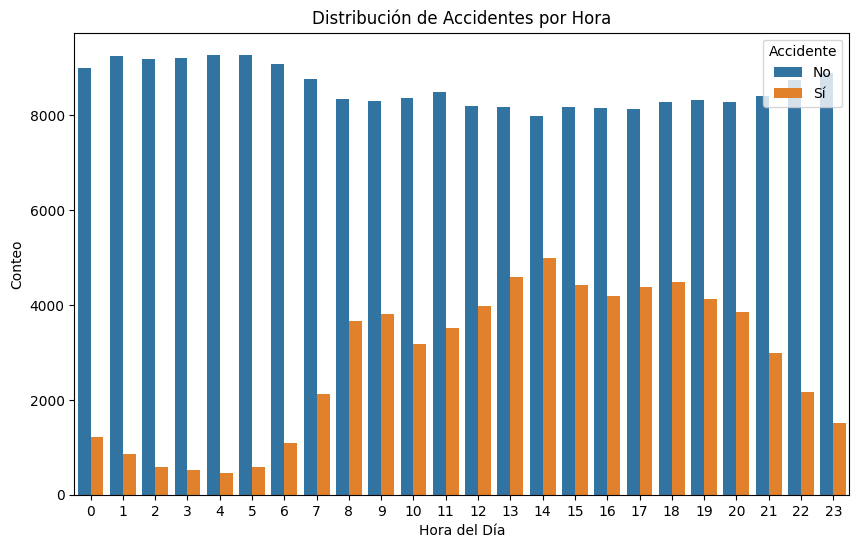

In [298]:
plt.figure(figsize=(10, 6))
sns.countplot(x='hora', hue='es_accidente', data=df_final)
plt.title('Distribución de Accidentes por Hora')
plt.xlabel('Hora del Día')
plt.ylabel('Conteo')
plt.legend(title='Accidente', labels=['No', 'Sí'])
plt.show()

- Vemos que la mayoria de los accidentes ocurren en horarios laborales, lo que es logico

----


> Analisis por dia de la semana

In [306]:
df_final.loc[:,'dia'] = df_final['Fecha'].dt.dayofweek + 1

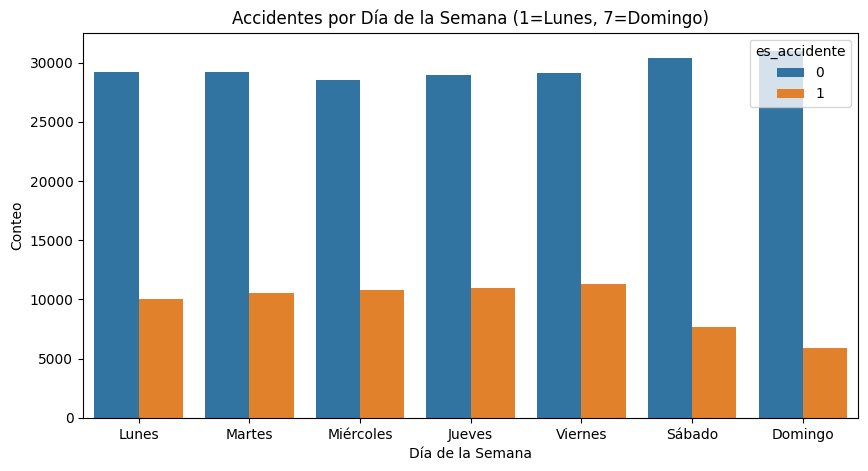

In [308]:
plt.figure(figsize=(10, 5))
sns.countplot(x='dia', hue='es_accidente', data=df_final, 
              order=[1, 2, 3, 4, 5, 6, 7])
plt.title('Accidentes por Día de la Semana (1=Lunes, 7=Domingo)')
plt.xlabel('Día de la Semana')
plt.ylabel('Conteo')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], 
           labels=['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'])
plt.show()


- Podemos observar que no hay mucha diferencia entre la distribucion de los accidentes en los dias de semana, siendo el viernes el dia con mas accidentes, levemente por encima de los demas.

---

> Analisis de accidentes por mes del año

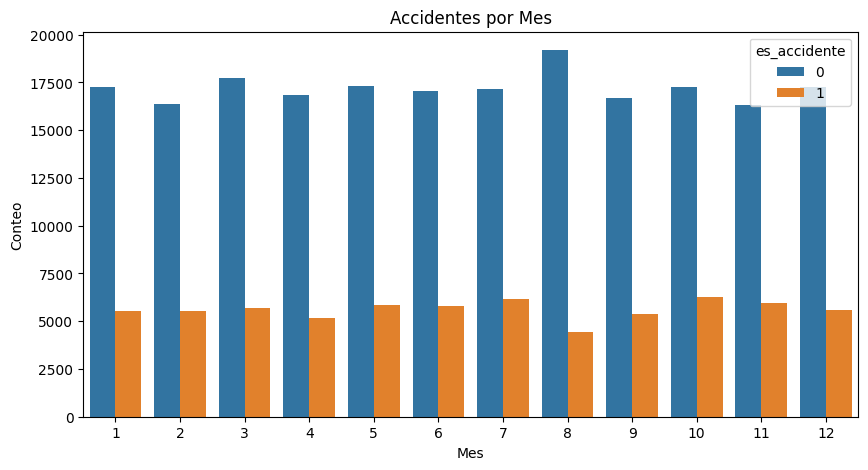

In [316]:
df_final.loc[:,'mes'] = df_final['Fecha'].dt.month
plt.figure(figsize=(10, 5))
sns.countplot(x='mes', hue='es_accidente', data=df_final)
plt.title('Accidentes por Mes')
plt.xlabel('Mes')
plt.ylabel('Conteo')
plt.show()


- Tampoco podemos observar ninguna diferencia notable entre los meses. Siendo levemente mayor la cantidad de accidentes registrados en Octubre.

-----

> Analisis del impacto del clima (Temperatura)

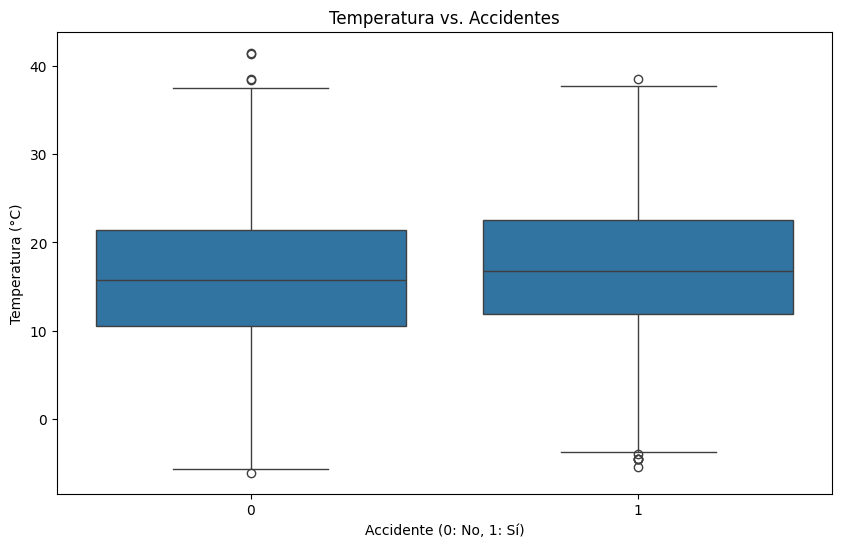

In [309]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='es_accidente', y='temperature_2m (°C)', data=df_final)
plt.title('Temperatura vs. Accidentes')
plt.xlabel('Accidente (0: No, 1: Sí)')
plt.ylabel('Temperatura (°C)')
plt.show()

> Precipitaciones

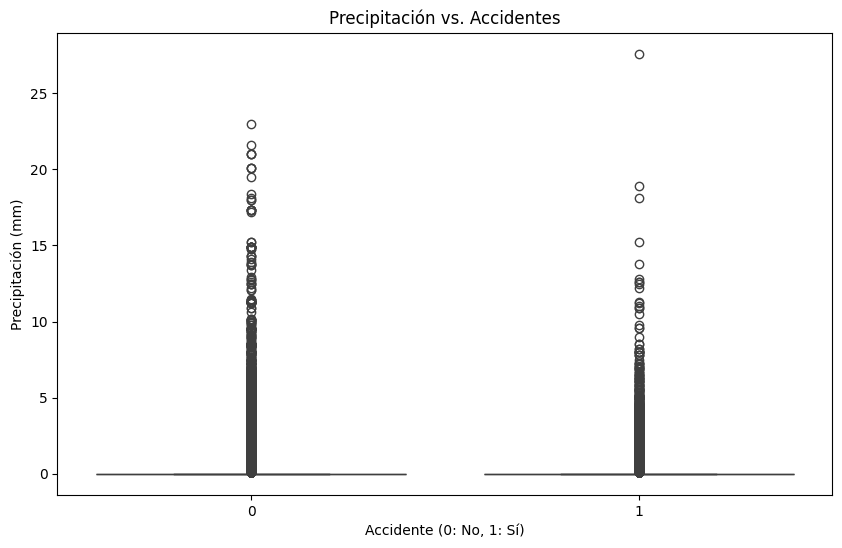

In [311]:
# Precipitación
plt.figure(figsize=(10, 6))
sns.boxplot(x='es_accidente', y='precipitation (mm)', data=df_final)
plt.title('Precipitación vs. Accidentes')
plt.xlabel('Accidente (0: No, 1: Sí)')
plt.ylabel('Precipitación (mm)')
plt.show()

- Basado en estos gráficos, la temperatura y la lluvia no parecen tener un impacto fuerte o directo en la probabilidad de que ocurra un accidente. La distribución es muy similar en ambos casos

- Los outliers en temperaturas extremas (muy altas o muy bajas) sugieren que podrías investigar más a fondo si los accidentes en estas condiciones son más frecuentes de lo esperado.

------

> Analisis por clusters

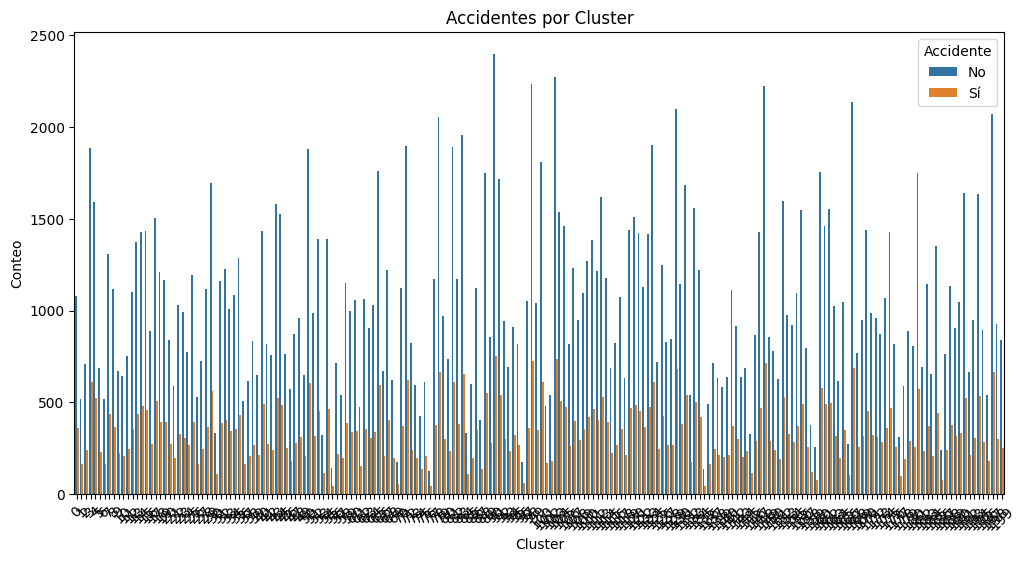

In [312]:
plt.figure(figsize=(12, 6))
sns.countplot(x='cluster', hue='es_accidente', data=df_final)
plt.title('Accidentes por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Conteo')
plt.xticks(rotation=45)
plt.legend(title='Accidente', labels=['No', 'Sí'])
plt.show()

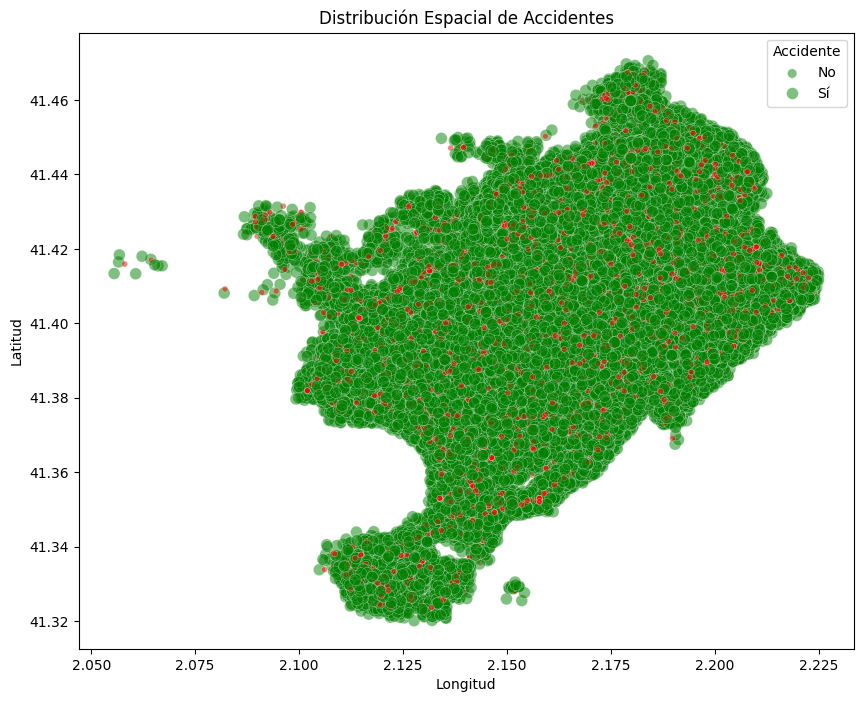

In [319]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='lon', y='lat', hue='es_accidente', size='es_accidente', 
                data=df_final, alpha=0.5, palette={0: 'green', 1: 'red'})
plt.title('Distribución Espacial de Accidentes')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend(title='Accidente', labels=['No', 'Sí'])
plt.show()



- Ponemos el mapa de barcelona de fondo y equilibramos

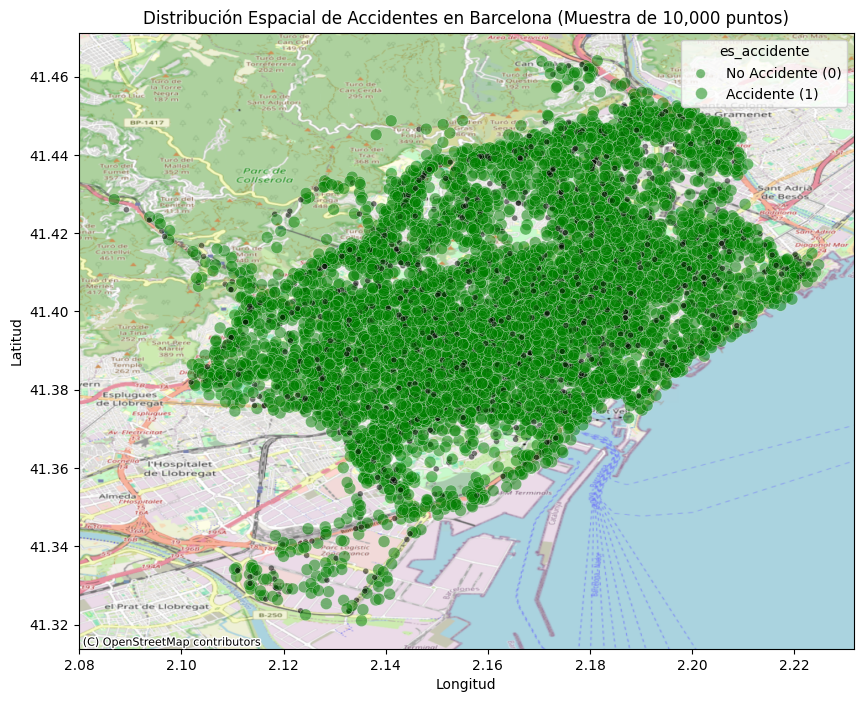

In [320]:
# Tomar una muestra de 10,000 puntos
df_sample = df_final.sample(10000, random_state=42)

# Convertir el DataFrame a GeoDataFrame
geometry = [Point(xy) for xy in zip(df_sample['lon'], df_sample['lat'])]
gdf = gpd.GeoDataFrame(df_sample, geometry=geometry, crs="EPSG:4326")

# Crear el gráfico
fig, ax = plt.subplots(figsize=(10, 8))

# Graficar los puntos con seaborn (usando GeoDataFrame)
sns.scatterplot(x='lon', y='lat', hue='es_accidente', size='es_accidente', 
                data=df_sample, alpha=0.5, ax=ax, palette={0: "green", 1: 'black'})

# Agregar el mapa base de Barcelona usando Contextily
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

# Personalizar el gráfico
plt.title('Distribución Espacial de Accidentes en Barcelona (Muestra de 10,000 puntos)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Ajustar la leyenda
plt.legend(title='es_accidente', labels=['No Accidente (0)', 'Accidente (1)'])

# Mostrar el gráfico
plt.show()

------

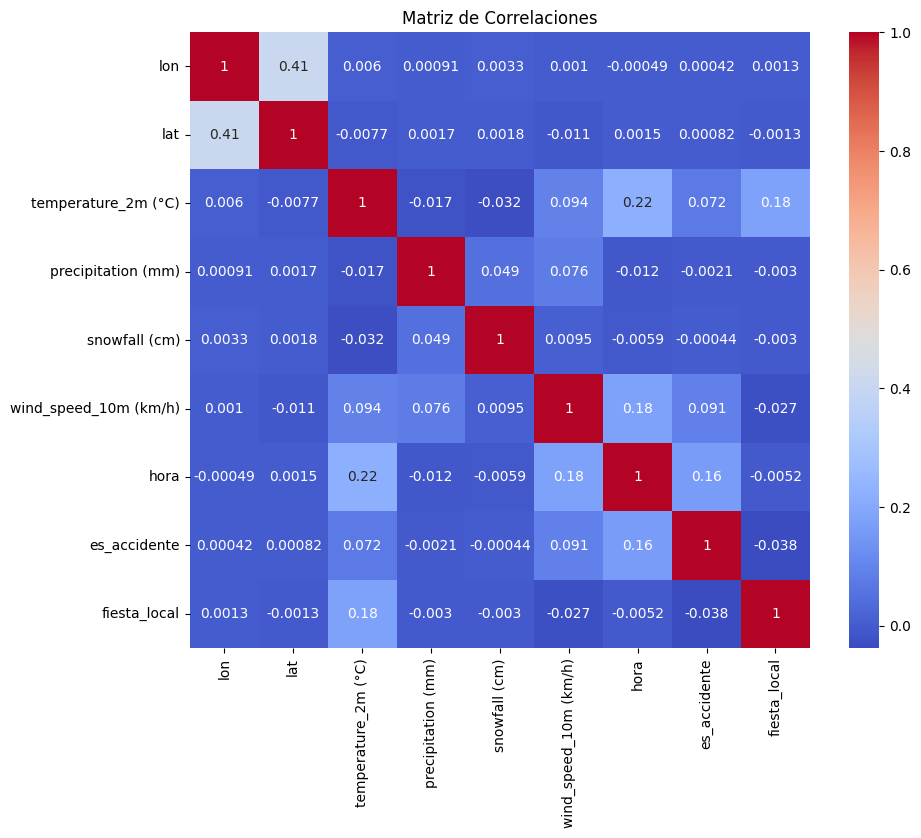

In [321]:
plt.figure(figsize=(10, 8))
numeric_cols = ['lon', 'lat', 'temperature_2m (°C)', 'precipitation (mm)', 
                'snowfall (cm)', 'wind_speed_10m (km/h)', 'hora', 'es_accidente', "fiesta_local"]
sns.heatmap(df_final[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlaciones')
plt.show()

In [323]:
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap

# Agrupar por cluster y calcular estadísticas
cluster_stats = df_final.groupby('cluster').agg({
    'lon': 'mean',  # Promedio de longitud por cluster
    'lat': 'mean',  # Promedio de latitud por cluster
    'es_accidente': 'sum',  # Total de accidentes (es_accidente = 1)
    'hora': 'count'  # Total de registros por cluster
}).reset_index()

# Calcular tasa de accidentes (porcentaje de registros con accidente)
cluster_stats['tasa_accidente'] = (cluster_stats['es_accidente'] / cluster_stats['hora']) * 100

# Seleccionar los 20 clusters con más accidentes
top_20_clusters = cluster_stats.nlargest(20, 'es_accidente')

# Crear un mapa centrado en el promedio de las latitudes y longitudes de los 20 clusters más problemáticos
map_center = [top_20_clusters['lat'].mean(), top_20_clusters['lon'].mean()]
mapa = folium.Map(location=map_center, zoom_start=10)

# Agregar círculos para los 20 clusters más problemáticos
for idx, row in top_20_clusters.iterrows():
    folium.Circle(
        location=[row['lat'], row['lon']],
        radius=row['tasa_accidente'] * 1000,  # Tamaño del círculo proporcional a la tasa (ajusta el factor 1000)
        color='red' if row['tasa_accidente'] > 5 else 'blue',  # Color según umbral (>5% rojo)
        fill=True,
        fill_opacity=0.6,
        popup=f"Cluster {int(row['cluster'])}<br>Tasa: {row['tasa_accidente']:.1f}%<br>Accidentes: {int(row['es_accidente'])}"
    ).add_to(mapa)

# Opcional: Agregar un HeatMap para los 20 clusters
heat_data = [[row['lat'], row['lon'], row['tasa_accidente']] for idx, row in top_20_clusters.iterrows()]
HeatMap(heat_data, radius=15).add_to(mapa)

# Guardar o mostrar el mapa
mapa.save('mapa_top_20_accidentes.html')  # Guarda como archivo HTML
# Para mostrar en Jupyter: mapa